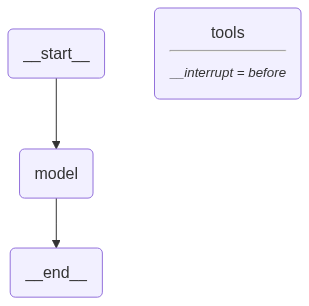

In [1]:
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode

from typing import Annotated, TypedDict, List

from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage

from IPython.display import Image, display


import sqlite3

load_dotenv()
groq_model = os.getenv("groq_model")

class BaseStateClass(TypedDict):
    messages: Annotated[List, add_messages]

sqlite_conn = sqlite3.connect('review_tool_call.sqlite', check_same_thread=False)
memory = SqliteSaver(sqlite_conn)

search_tools = TavilySearchResults(max_results = 2)
tools = [search_tools]

llm = ChatGroq(model = groq_model)
llm_with_tools = llm.bind_tools(tools= tools)

def model(state: BaseStateClass):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BaseStateClass):
    last_message = state["messages"][-1].content

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls)> 0):
        return "tools"
    else:
        return END

tools = ToolNode(tools = tools)    
graph = StateGraph(BaseStateClass)

graph.add_node("model", model)
graph.add_node("tools", tools)

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)
graph.add_edge("tools", "model")

app = graph.compile(checkpointer= memory, interrupt_before=["tools"])

display(Image(app.get_graph().draw_mermaid_png()))


In [2]:

config = {"configurable": {"thread_id": "1"}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current wether in lalitpur")]
}, config= config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

print(app.get_state(config= config).next)

================================ Human Message =================================

What is the current wether in lalitpur
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1jcbaray0)
 Call ID: 1jcbaray0
  Args:
    query: Lalitpur weather current
()


In [3]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1jcbaray0)
 Call ID: 1jcbaray0
  Args:
    query: Lalitpur weather current
